[*********************100%***********************]  6 of 6 completed


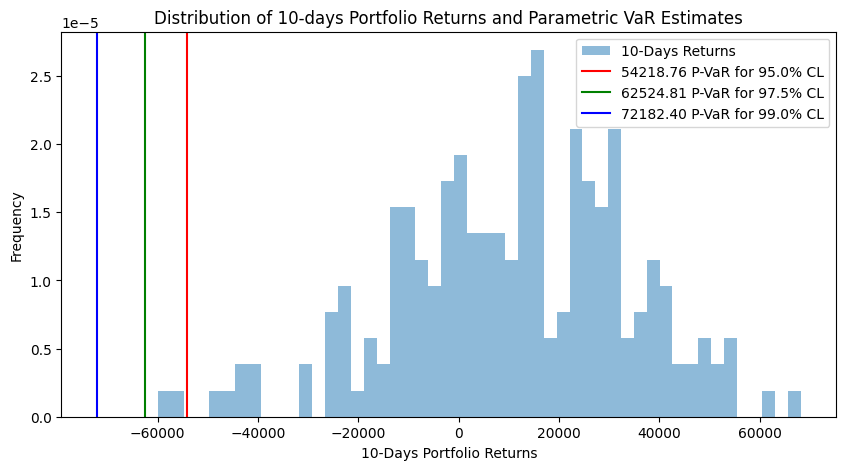

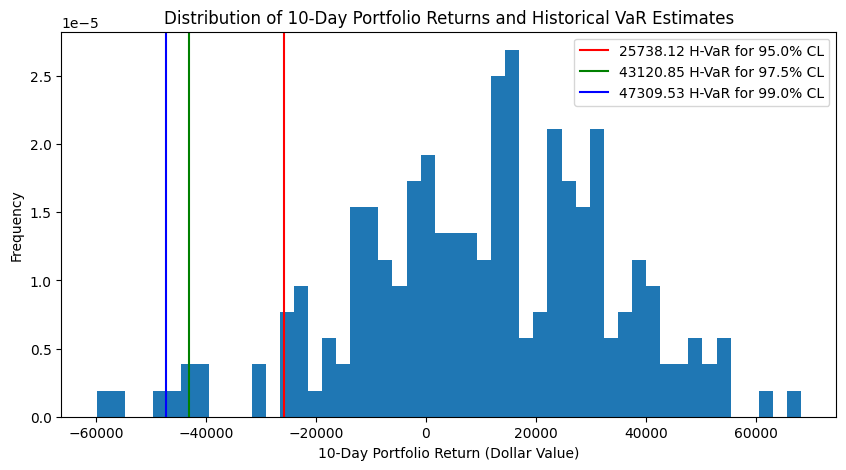

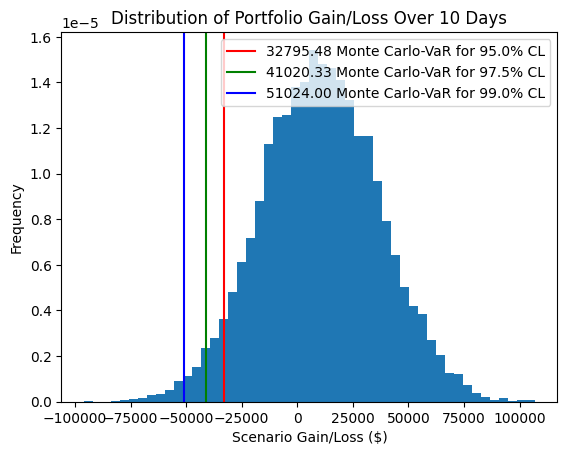


Confidence Level     Parametric VaR       Historical VaR       Monte Carlo VaR     
--------------------------------------------------------------------------------
    95%:          $  54218.76          $  25738.12          $  32795.48
    98%:          $  62524.81          $  43120.85          $  41020.33
    99%:          $  72182.40          $  47309.53          $  51024.00

Parametric VaR Model:
{0.95: 'Green Zone', 0.975: 'Green Zone', 0.99: 'Green Zone'}
{0.95: 'Reliable', 0.975: 'Reliable', 0.99: 'Reliable'}

Historical VaR Model:
{0.95: 'Green Zone', 0.975: 'Green Zone', 0.99: 'Green Zone'}
{0.95: 'Reliable', 0.975: 'Reliable', 0.99: 'Reliable'}

Monte Carlo VaR Model:
{0.95: 'Green Zone', 0.975: 'Green Zone', 0.99: 'Green Zone'}
{0.95: 'Reliable', 0.975: 'Reliable', 0.99: 'Reliable'}

Confidence Level     Parametric CVaR      Historical CVaR      Monte Carlo CVaR    
--------------------------------------------------------------------------------
    95%:          $       na

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm, chi2
from IPython import get_ipython
from IPython.display import display

class PortfolioRisk:
    def __init__(self, tickers, start_date, end_date, portfolio_value=1000000):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.portfolio_value = portfolio_value
        self.data = self.download_data()
        self.daily_return = self.calculate_daily_returns()
        self.weights = np.array([1 / len(self.tickers)] * len(self.tickers))
        self.portfolio_returns = self.calculate_portfolio_returns()

    def download_data(self):
        data = yf.download(self.tickers, start=self.start_date, end=self.end_date, auto_adjust=False)['Adj Close']
        return data.dropna()

    def calculate_daily_returns(self):
        return np.log(self.data / self.data.shift(1)).dropna()

    def calculate_portfolio_returns(self):
        return (self.daily_return * self.weights).sum(axis=1)

    def calculate_parametric_var(self, confidence_level, days=10):
        trading_days = 252
        parametric_cov = self.daily_return.cov() * trading_days #check
        std_dev = np.sqrt(self.weights.T @ parametric_cov @ self.weights)
        mean = np.mean(self.portfolio_returns)
        p_vars = []
        for confidence in confidence_level:
            p_var = -self.portfolio_value * (norm.ppf(1 - confidence) * std_dev * np.sqrt(days / 252) - mean * days) #check
            p_vars.append(p_var)
        return p_vars

    def plot_parametric_var(self, p_vars, days=10):
        p_x_day_returns = self.portfolio_returns.rolling(window=days).sum().dropna() * self.portfolio_value
        plt.figure(figsize=(10, 5))
        plt.hist(p_x_day_returns, bins=50, alpha=0.5, density=True, label=f'{days}-Days Returns')
        for var, cl, color in zip(p_vars, [0.95, 0.975, 0.99], ['r', 'g', 'b']):
            plt.axvline(-var, color=color, linestyle='-', label=f'{var:.2f} P-VaR for {cl * 100}% CL')
        plt.xlabel(f'{days}-Days Portfolio Returns')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {days}-days Portfolio Returns and Parametric VaR Estimates')
        plt.legend()
        plt.show()

    def calculate_historical_var(self, confidence_level, days=10):
        historical_x_day_returns = self.portfolio_returns.rolling(window=days).sum().dropna()
        h_vars = []
        for cl in confidence_level:
            h_var = -np.percentile(historical_x_day_returns, 100 - (cl * 100)) * self.portfolio_value
            h_vars.append(h_var)
        return h_vars

    def plot_historical_var(self, h_vars, days=10):
        range_returns_dollar = self.portfolio_returns.rolling(window=days).sum().dropna() * self.portfolio_value
        plt.figure(figsize=(10, 5))
        plt.hist(range_returns_dollar, bins=50, density=True)
        plt.xlabel(f'{days}-Day Portfolio Return (Dollar Value)')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {days}-Day Portfolio Returns and Historical VaR Estimates')
        for h_var, cl, color in zip(h_vars, [0.95, 0.975, 0.99], ['r', 'g', 'b']):
            plt.axvline(-h_var, color=color, linestyle='-', label=f'{h_var:.2f} H-VaR for {cl * 100}% CL')
        plt.legend()
        plt.show()

    def calculate_monte_carlo_var(self, confidence_level, days=10, simulations=10000):
        cov_matrix = self.daily_return.cov()
        portfolio_expected_return = np.sum(self.daily_return.mean() * self.weights)
        portfolio_std_dev = np.sqrt(self.weights.T @ cov_matrix @ self.weights)

        self.scenario_returns = []
        for _ in range(simulations):
            z_score = np.random.normal(0, 1)
            scenario_gain_loss = self.portfolio_value * portfolio_expected_return * days + self.portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)
            self.scenario_returns.append(scenario_gain_loss)

        mc_vars = []
        for cl in confidence_level:
            mc_var = -np.percentile(self.scenario_returns, 100 * (1 - cl))
            mc_vars.append(mc_var)
        return mc_vars

    def plot_monte_carlo_var(self, mc_vars, days=10, simulations=10000):
        plt.hist(self.scenario_returns, bins=50, density=True)
        plt.xlabel('Scenario Gain/Loss ($)')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
        for mc_var, cl, color in zip(mc_vars, [0.95, 0.975, 0.99], ['r', 'g', 'b']):
            plt.axvline(-mc_var, color=color, linestyle='-', label=f'{mc_var:.2f} Monte Carlo-VaR for {cl * 100}% CL')
        plt.legend()
        plt.show()

    def traffic_light_test(self, model_vars, confidence_level):
        results = {}
        for i, cl in enumerate(confidence_level):
            exceedances = (self.portfolio_returns * self.portfolio_value < -model_vars[i]).sum()
            if exceedances < 5 and exceedances >= 0:
                results[cl] = "Green Zone"
            elif exceedances < 9 and exceedances >= 5:
                results[cl] = "Yellow Zone"
            else:
                results[cl] = "Red Zone"
        return results

    def kupiec_test(self, var_model, confidence_level):
        results = {}
        for i, cl in enumerate(confidence_level):
            x = (self.portfolio_returns * self.portfolio_value < -var_model[i]).sum()
            n = len(self.portfolio_returns)
            p = 1 - cl
            p_hat = x / n
            LR_statistic = -2 * np.log(((p ** x) * ((1 - p) ** (n - x))) / ((p_hat ** x) * ((1 - p_hat) ** (n - x))))
            p_value = chi2.cdf(LR_statistic, df=1)
            if p_value > 0.05:
                results[cl] = "Reliable"
            else:
                results[cl] = "Not Reliable"
        return results

    def calculate_expected_shortfall(self, model_vars, confidence_level, days=10):
        cvars = []
        for mv, cl in zip(model_vars ,confidence_level):
            cvar= self.portfolio_returns[self.portfolio_returns < (-mv/self.portfolio_value)].mean()#check
            cvars.append(-cvar)
        return cvars

if __name__ == "__main__":
    # Define parameters in the main block
    tickers = ['KOTAKBANK.NS', 'ICICIBANK.NS', '5876.TW', '3988.HK', 'MUFG', 'SMFG']
    start_date = '2023-07-14'
    end_date = '2024-07-14'
    confidence_level = [0.95, 0.975, 0.99]
    portfolio_value = 1000000
    days = 10

    # Create a PortfolioRisk object
    portfolio_risk = PortfolioRisk(tickers, start_date, end_date, portfolio_value)

    # Calculate and print VaR values
    p_vars = portfolio_risk.calculate_parametric_var(confidence_level, days)
    h_vars = portfolio_risk.calculate_historical_var(confidence_level, days)
    mc_vars = portfolio_risk.calculate_monte_carlo_var(confidence_level, days)

    # Calculate and print CVaR values
    p_cvars = portfolio_risk.calculate_expected_shortfall(p_vars, confidence_level, days)
    h_cvars = portfolio_risk.calculate_expected_shortfall(h_vars, confidence_level, days)
    mc_cvars = portfolio_risk.calculate_expected_shortfall(mc_vars, confidence_level, days)

    #Plot the diagrams
    portfolio_risk.plot_parametric_var(p_vars, days)
    portfolio_risk.plot_historical_var(h_vars, days)
    portfolio_risk.plot_monte_carlo_var(mc_vars, days)

    # Print VaR results
    print(f'\n{"Confidence Level":<20} {"Parametric VaR":<20} {"Historical VaR":<20} {"Monte Carlo VaR":<20}')
    print('-' * 80)
    for cl, p_var, h_var, mc_var in zip(confidence_level, p_vars, h_vars, mc_vars):
        print(f'{cl * 100:>6.0f}%: {"":<8} ${p_var:>10.2f} {"":<8} ${h_var:>10.2f} {"":<8} ${mc_var:>10.2f}')

    # Perform Backtesting
    print("\nParametric VaR Model:")
    print(portfolio_risk.traffic_light_test(p_vars, confidence_level))
    print(portfolio_risk.kupiec_test(p_vars, confidence_level))

    print("\nHistorical VaR Model:")
    print(portfolio_risk.traffic_light_test(h_vars, confidence_level))
    print(portfolio_risk.kupiec_test(h_vars, confidence_level))

    print("\nMonte Carlo VaR Model:")
    print(portfolio_risk.traffic_light_test(mc_vars, confidence_level))
    print(portfolio_risk.kupiec_test(mc_vars, confidence_level))

    # Print CVaR results
    print(f'\n{"Confidence Level":<20} {"Parametric CVaR":<20} {"Historical CVaR":<20} {"Monte Carlo CVaR":<20}')
    print('-' * 80)
    for cl, p_cvar, h_cvar, mc_cvar in zip(confidence_level, p_cvars, h_cvars, mc_cvars):
        print(f'{cl * 100:>6.0f}%: {"":<8} ${p_cvar:>10.2f} {"":<8} ${h_cvar:>10.2f} {"":<8} ${mc_cvar:>10.2f}')
